In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from pyvis.network import Network
from node2vec import Node2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from sentence_transformers import SentenceTransformer

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GATConv           
from torch_geometric.nn import GINConv
from torch_geometric.nn import SAGEConv

/home/hakan/myEnv/532_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

KEYWORD_SIM_THRESHOLD = 0.4 
AUTHOR_MIN_OVERLAP = 1
NODE2VEC_DIMENSION = 64
NODE2VEC_WALK_LENGTH = 30
NODE2VEC_NUM_OF_WALKS = 40
NODE2VEC_P, NODE2VEC_Q = 0.5, 1.5
ABSTRACT_SIMILARITY_THRESHOLD = 0.70
TITLE_SIMILARITY_THRESHOLD = 0.80
CLUSTER_COUNT = 12
DROPOUT = 0.5
LEARNING_RATE = 0.01


In [3]:
# Jaccard similarity helper function

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:
        return 0
    return len(intersection) / len(union)


In [4]:
# Load JSON data

with open('532_data.json', encoding='utf-8') as f:
    papers = json.load(f)

In [5]:
# Create a graph

G = nx.Graph()

In [6]:
# Add nodes for each paper

for paper in papers:
    paper_id = paper["url"].split("/")[-1]
    G.add_node(
        paper_id,
        title=paper.get("title", ""),
        abstract=paper.get("abstract", ""),
        keywords=paper.get("keywords", []),
        authors=paper.get("authors", []),
        type="paper"
    )

In [7]:
# Example of the first node with all attributes
node_id, node_data = list(G.nodes(data=True))[0]

print("Node id")
print(node_id)
print("\n")

print("Title:")
print(node_data["title"])
print("\n")

print("Keywords:")
for kw in node_data["keywords"]:
    print(kw)
print("\n")

print("Authors:")
for author in node_data["authors"]:
    print(author)
print("\n")

print("Abstract:")
print(node_data["abstract"])

Node id
368013


Title:
The Effect of CuttingTool Wear Behaviors on Feed  Rates in Turning of Metal Matrix Composites


Keywords:
Metal MatrixComposites (MMCs)
Machinability
MgO
Tool wear
Built up edge (BUE)


Authors:
Muharrem Pul
Ulvi Şeker


Abstract:
Composite materials, one of them is metal matrix composites (MMCs), is a group of engineering materials whose application fields expand rapidly. In this study, to make an interpretation on machinability of MMCs materials, MMCs materials reinforced Al matrix and MgO which were produced in 5%, 10% and 15% reinforcement-volumeratios (R-V) were subjected to machining tests by carbide (C) and coated carbide (CC) cutting tools. Machining tests were conducted with 300 m/dak cutting speed, at three different feed rates (0.075, 0.15 and 0.225 mm/dev) and fixed depth of cut (1 mm). After the machining tests, wear characteristics were examined by the help of scanning electron microscope (SEM) views of cuttingtools and the findings were discussed.

In [8]:
# Add edges based on shared keywords or shared authors

nodes = list(G.nodes)
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        node1 = nodes[i]
        node2 = nodes[j]

        # Shared keywords with Jaccard similarity
        keywords1 = set(G.nodes[node1].get('keywords', []))
        keywords2 = set(G.nodes[node2].get('keywords', []))
        keyword_similarity = jaccard_similarity(keywords1, keywords2)

        if keyword_similarity >= KEYWORD_SIM_THRESHOLD:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

        # Shared authors with count threshold
        authors1 = set(G.nodes[node1].get('authors', []))
        authors2 = set(G.nodes[node2].get('authors', []))
        shared_authors = authors1.intersection(authors2)

        if len(shared_authors) >= AUTHOR_MIN_OVERLAP:
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

In [9]:
len(G.edges)

4075

In [10]:
abstracts = [G.nodes[node]["abstract"] for node in G.nodes()]
titles = [G.nodes[node]["title"] for node in G.nodes()]

embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")


abstract_embeddings = embedding_model.encode(sentences=abstracts, normalize_embeddings=True, show_progress_bar=True)
print("\n")
title_embeddings = embedding_model.encode(sentences=titles, normalize_embeddings=True, show_progress_bar=True)



Batches: 100%|██████████| 59/59 [00:05<00:00,  9.88it/s]


Batches: 100%|██████████| 59/59 [00:01<00:00, 42.56it/s]


In [11]:
abstract_sim_matrix = cosine_similarity(abstract_embeddings)

title_sim_matrix = cosine_similarity(title_embeddings)

In [12]:
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        if abstract_sim_matrix[i][j] > ABSTRACT_SIMILARITY_THRESHOLD or title_sim_matrix[i][j] > TITLE_SIMILARITY_THRESHOLD :
            node1 = nodes[i]
            node2 = nodes[j]
            if not G.has_edge(node1, node2):
                G.add_edge(node1, node2)

In [13]:
len(G.edges)

4843

In [14]:
graph_node_id_list = list(G.nodes())

In [15]:
node2vec = Node2Vec(G, dimensions=NODE2VEC_DIMENSION, walk_length=NODE2VEC_WALK_LENGTH, num_walks=NODE2VEC_NUM_OF_WALKS, workers=8, p=NODE2VEC_P, q=NODE2VEC_Q)
node2vec_model = node2vec.fit(window=15, min_count=1, batch_words=8)
node2vec_embeddings = [node2vec_model.wv[node] for node in graph_node_id_list]

Generating walks (CPU: 8): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


In [18]:
def find_similar_papers_by_embedding(query_text, embeddings_np, node_list, top_k=5):
    
    query_embedding = embedding_model.encode([query_text])[0]
    similarities = cosine_similarity([query_embedding], embeddings_np)[0]
    top_indices = similarities.argsort()[::-1][1:top_k+1]

    print(f"\nTop {top_k} similar papers for query:\n\"{query_text}\"\n")
    for idx in top_indices:
        node_id = node_list[idx]
        data = G.nodes[node_id]

        print(f"Paper ID: {node_id}")
        print(f"Title: {data['title']}")
        print(f"Similarity Score: {similarities[idx]:.4f}")
        print(f"Authors: {', '.join(data.get('authors', []))}")
        print("="*30, "\n")

In [20]:
search_node_id = "1327987"

query_s = G.nodes[search_node_id]["abstract"]
find_similar_papers_by_embedding(query_s, np.array(abstract_embeddings), list(G.nodes()), top_k=5)


Top 5 similar papers for query:
"The election of an appropriate data center network topology is key when dealing with surveillance and monitoring processes, such as those devoted to obtaining relevant data for sensor data fusion in any type of remote computing environment so as to perform fault diagnosis and prevention. In this paper, some of the most commonly used topologies to interconnect nodes within a data center bound to edge/fog computing, representing either switch-centric ones or server-centric ones, are reviewed and analyzed from a statistical point of view in order to measure their performance, resulting in server-centric ones doing it better."

Paper ID: 810896
Title: Arithmetic Study about Energy Save in Switches for some Data Centre Topologies
Similarity Score: 0.7047
Authors: Pedro Juan Roig, Salvador Alcaraz, Katja Gılly, Carlos Juiz

Paper ID: 1327964
Title: Applying Toroidal k-ary Grids for Optimizing Edge Data Centers
Similarity Score: 0.6276
Authors: Pedro Juan Roi

In [19]:
connected_nodes = [node for node in G.nodes if G.degree(node) > 0]
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]

print(len(connected_nodes))
print(len(isolated_nodes))

1441
427


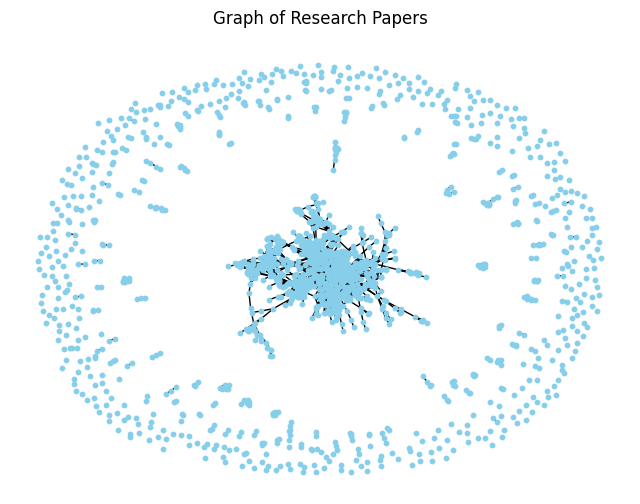

In [20]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=1)

plt.title("Graph of Research Papers")
plt.axis("off")
plt.show()

In [21]:
inertia = []
k_values = range(6, 24) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=532)
    kmeans.fit(node2vec_embeddings)
    inertia.append(kmeans.inertia_)

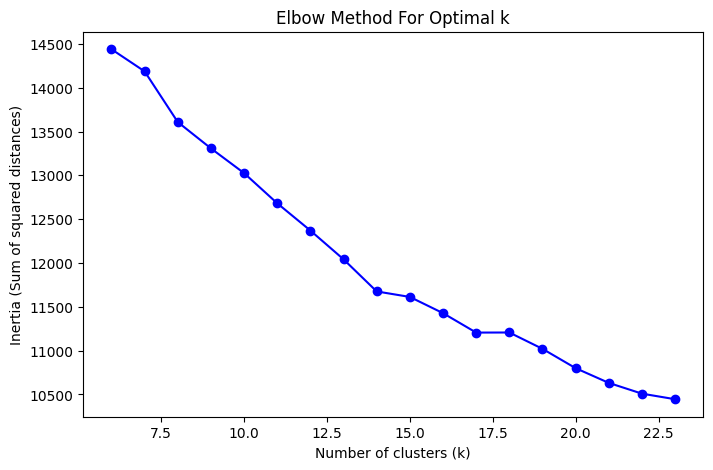

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
sil_scores = []
k_values = range(6, 24) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=532)
    labels = kmeans.fit_predict(node2vec_embeddings)
    sil_scores.append(silhouette_score(node2vec_embeddings, labels))

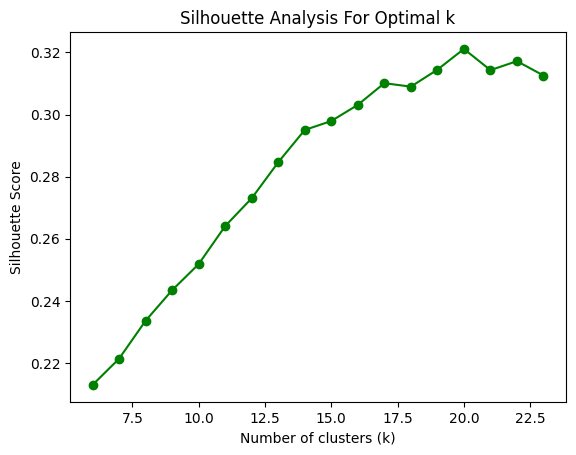


Best number of clusters by silhouette score: k=20 with score=0.3211


In [24]:
plt.plot(range(6, 24), sil_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

best_k = k_values[sil_scores.index(max(sil_scores))]
best_score = max(sil_scores)

print(f"\nBest number of clusters by silhouette score: k={best_k} with score={best_score:.4f}")

In [25]:
kmeans = KMeans(n_clusters=best_k, random_state=532)
cluster_labels = kmeans.fit_predict(node2vec_embeddings)

for node_id, cluster_id in zip(graph_node_id_list, cluster_labels):
    G.nodes[node_id]['cluster'] = cluster_id

/tmp/ipykernel_6098/584797849.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_clusters)


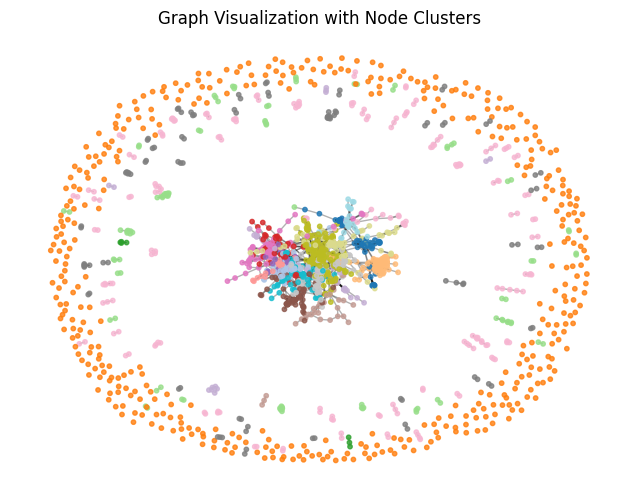

In [41]:
cluster_labels = [G.nodes[n].get('cluster', -1) for n in G.nodes()]
num_clusters = max(cluster_labels) + 1 

cmap = plt.cm.get_cmap('tab20', num_clusters)

node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in cluster_labels]

plt.figure(figsize=(8, 6))

pos = nx.spring_layout(G, seed=532) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Graph Visualization with Node Clusters")
plt.axis('off')
plt.show()

In [28]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)

num_clusters = max(cluster_labels) + 1
cmap = plt.cm.get_cmap('tab20', num_clusters)
cluster_labels = [G.nodes[n].get('cluster', -1) for n in G.nodes()]
node_colors = [cmap(label) if label >= 0 else (0, 0, 0, 0.8) for label in cluster_labels]

for i, node in enumerate(G.nodes()):
    cluster_id = cluster_labels[i]
    color = node_colors[i]
    color_hex = '#{:02x}{:02x}{:02x}'.format(
        int(color[0]*255), int(color[1]*255), int(color[2]*255)
    )
    #title = G.nodes[node].get("title", "No Title")
    net.add_node(node, label=str(cluster_id), color=color_hex)

for source, target in G.edges():
    net.add_edge(source, target)

net.show("node2vec_sentence_transformer_version.html")

/tmp/ipykernel_6098/3809567632.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_clusters)


node2vec_sentence_transformer_version.html


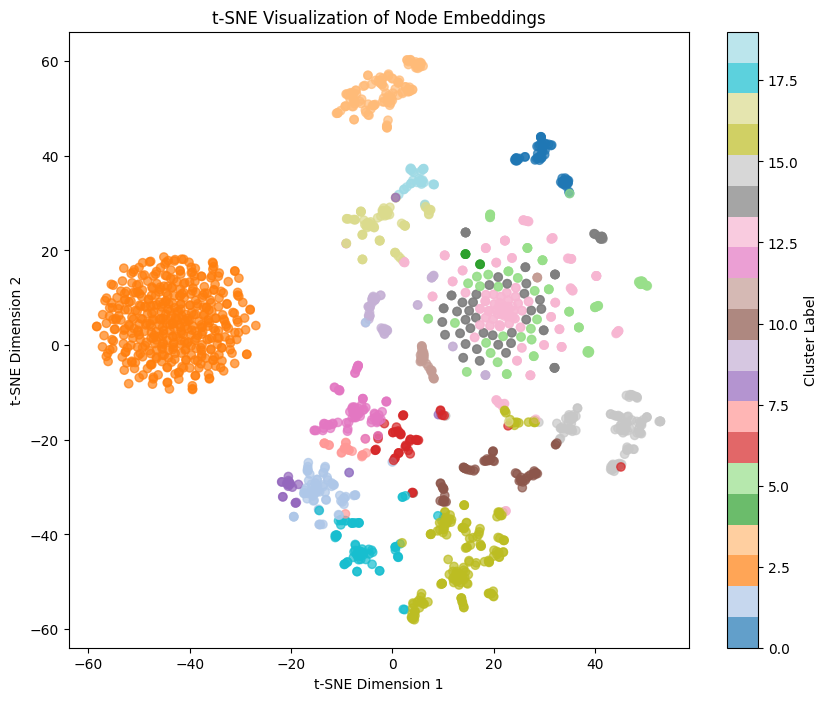

In [29]:
tsne = TSNE(n_components=2, random_state=532)
embeddings_2d = tsne.fit_transform(np.array(node2vec_embeddings))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=cluster_labels, cmap='tab20', alpha=0.7
)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [30]:
data = from_networkx(G)

data.x = torch.tensor(node2vec_embeddings, dtype=torch.float)
data.y = torch.tensor(cluster_labels, dtype=torch.long)

/tmp/ipykernel_6098/2245226150.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  data.x = torch.tensor(node2vec_embeddings, dtype=torch.float)


In [31]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [32]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [33]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [34]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, out_channels))
        self.conv2 = GINConv(nn2)

    def forward(self, x):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [35]:
def train_and_evaluate_gnn(model, data, epochs=100, print_every=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    data = data.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            model.eval()
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            model.train()

    model.eval()
    out = model(data)
    pred = out.argmax(dim=1).cpu().numpy()
    true = data.y.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    pred_test = pred[test_mask]
    true_test = true[test_mask]

    precision, recall, f1, _ = precision_recall_fscore_support(true_test, pred_test, average=None)
    print("\nPer-class precision:", [(i, prec) for i, prec in enumerate(precision) if prec != 1])
    print("Per-class recall:", [(i, rec) for i, rec in enumerate(recall) if rec != 1])
    print("Per-class F1-score:", [(i, f) for i, f in enumerate(f1) if f != 1])

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(true_test, pred_test, average='macro')
    print(f"\nMacro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")

    accuracy = accuracy_score(true_test, pred_test)
    print(f"\nTest Accuracy: {accuracy:.4f}")

In [36]:
labels = data.y.cpu().numpy()
idx = np.arange(len(labels))

train_idx, test_idx = train_test_split(idx, test_size=0.3, stratify=labels, random_state=532)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=labels[train_idx], random_state=532)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [37]:
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=num_clusters, dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 3.0047, Val Loss: 2.7148
Epoch 10, Train Loss: 1.4758, Val Loss: 1.2302
Epoch 20, Train Loss: 0.7104, Val Loss: 0.4975
Epoch 30, Train Loss: 0.3474, Val Loss: 0.1704
Epoch 40, Train Loss: 0.1924, Val Loss: 0.1026
Epoch 50, Train Loss: 0.2538, Val Loss: 0.0828
Epoch 60, Train Loss: 0.1564, Val Loss: 0.0725
Epoch 70, Train Loss: 0.1201, Val Loss: 0.0702
Epoch 80, Train Loss: 0.1578, Val Loss: 0.0664
Epoch 90, Train Loss: 0.1280, Val Loss: 0.0652

Per-class precision: [(0, 0.9473684210526315), (12, 0.92), (15, 0.9459459459459459), (16, 0.9821428571428571), (18, 0.9565217391304348)]
Per-class recall: [(1, 0.9090909090909091), (5, 0.9666666666666667), (6, 0.9285714285714286), (7, 0.8571428571428571), (10, 0.9444444444444444), (13, 0.9830508474576272)]
Per-class F1-score: [(0, 0.972972972972973), (1, 0.9523809523809523), (5, 0.9830508474576272), (6, 0.9629629629629629), (7, 0.9230769230769231), (10, 0.9714285714285714), (12, 0.9583333333333334), (13, 0.9914529914529915),

In [38]:
model = GAT(in_channels=data.x.shape[1], hidden_channels=64, out_channels=num_clusters, dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 3.0700, Val Loss: 2.4653
Epoch 10, Train Loss: 0.8077, Val Loss: 0.3966
Epoch 20, Train Loss: 0.7071, Val Loss: 0.0858
Epoch 30, Train Loss: 0.6680, Val Loss: 0.0636
Epoch 40, Train Loss: 0.6151, Val Loss: 0.0613
Epoch 50, Train Loss: 0.5820, Val Loss: 0.0714
Epoch 60, Train Loss: 0.5857, Val Loss: 0.0742
Epoch 70, Train Loss: 0.5613, Val Loss: 0.0680
Epoch 80, Train Loss: 0.5411, Val Loss: 0.0552
Epoch 90, Train Loss: 0.4684, Val Loss: 0.0684

Per-class precision: [(0, 0.9473684210526315), (6, 0.9285714285714286), (14, 0.9354838709677419), (15, 0.9459459459459459), (16, 0.9821428571428571)]
Per-class recall: [(5, 0.9), (6, 0.9285714285714286), (7, 0.8571428571428571), (10, 0.9444444444444444), (13, 0.9830508474576272)]
Per-class F1-score: [(0, 0.972972972972973), (5, 0.9473684210526315), (6, 0.9285714285714286), (7, 0.9230769230769231), (10, 0.9714285714285714), (13, 0.9914529914529915), (14, 0.9666666666666667), (15, 0.9722222222222222), (16, 0.990990990990991)]


In [39]:
model = GraphSAGE(in_channels=data.x.shape[1], hidden_channels=64, out_channels=num_clusters, dropout=DROPOUT)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 3.0158, Val Loss: 2.6742
Epoch 10, Train Loss: 1.1398, Val Loss: 0.8656
Epoch 20, Train Loss: 0.5359, Val Loss: 0.3464
Epoch 30, Train Loss: 0.2422, Val Loss: 0.1072
Epoch 40, Train Loss: 0.1774, Val Loss: 0.0754
Epoch 50, Train Loss: 0.1676, Val Loss: 0.0809
Epoch 60, Train Loss: 0.1383, Val Loss: 0.0663
Epoch 70, Train Loss: 0.1784, Val Loss: 0.0734
Epoch 80, Train Loss: 0.1230, Val Loss: 0.0551
Epoch 90, Train Loss: 0.0883, Val Loss: 0.0614

Per-class precision: [(0, 0.9473684210526315), (12, 0.92), (13, 0.9830508474576272), (14, 0.9666666666666667), (15, 0.9722222222222222), (16, 0.9821428571428571)]
Per-class recall: [(1, 0.9545454545454546), (5, 0.9), (6, 0.9285714285714286), (7, 0.8571428571428571), (13, 0.9830508474576272)]
Per-class F1-score: [(0, 0.972972972972973), (1, 0.9767441860465116), (5, 0.9473684210526315), (6, 0.9629629629629629), (7, 0.9230769230769231), (12, 0.9583333333333334), (13, 0.9830508474576272), (14, 0.9830508474576272), (15, 0.9859154

In [40]:
model = GIN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=num_clusters)
train_and_evaluate_gnn(model, data, epochs=100)

Epoch 0, Train Loss: 7.3980, Val Loss: 3.5815
Epoch 10, Train Loss: 1.4626, Val Loss: 1.5466
Epoch 20, Train Loss: 0.8319, Val Loss: 1.0896
Epoch 30, Train Loss: 0.2839, Val Loss: 0.7084
Epoch 40, Train Loss: 0.0588, Val Loss: 0.7243
Epoch 50, Train Loss: 0.0193, Val Loss: 0.5514
Epoch 60, Train Loss: 0.0099, Val Loss: 0.5361
Epoch 70, Train Loss: 0.0064, Val Loss: 0.5777
Epoch 80, Train Loss: 0.0048, Val Loss: 0.5847
Epoch 90, Train Loss: 0.0040, Val Loss: 0.5664

Per-class precision: [(0, 0.9473684210526315), (5, 0.9354838709677419), (6, 0.9285714285714286), (7, 0.8333333333333334), (12, 0.9583333333333334), (14, 0.9642857142857143), (15, 0.9722222222222222), (16, 0.9482758620689655)]
Per-class recall: [(1, 0.9090909090909091), (3, 0.972972972972973), (5, 0.9666666666666667), (6, 0.9285714285714286), (7, 0.7142857142857143), (10, 0.9444444444444444), (13, 0.9830508474576272), (14, 0.9310344827586207)]
Per-class F1-score: [(0, 0.972972972972973), (1, 0.9523809523809523), (3, 0.9863013